## Get NDBC buoy names


issue: https://github.com/ioos/notebooks_demos/issues/351

GTS Statistics

The GTS monthly reports show the number of messages released to the GTS for each station. The reports contain the following fields:

Location ID - Identifier that station messages are released under to the GTS
Region - Designated IOOS Regional Association (only for IOOS regional report)
Sponsor - Organization that owns and maintains the station
Met - Total number of met messages released to the GTS
Wave - Total number of wave messages released to the GTS

In [1]:
import pandas as pd
import requests
import xml.etree.ElementTree as et


def make_ndbc_table():
    url = "https://www.ndbc.noaa.gov/activestations.xml"
    with requests.get(url) as r:
        elems = et.fromstring(r.content)
    df = pd.DataFrame([elem.attrib for elem in list(elems)])
    df["id"] = df["id"].str.lower()
    return df.set_index("id").T


buoys = make_ndbc_table()

In [2]:
from datetime import date
from erddapy import ERDDAP


# currently the ERDDAP server has data from
# 2019-01-01T00:00:00Z to 2020-06-01T00:00:00Z
min_date = "2019-01-01T00:00:00Z"
max_date = "2020-06-01T00:00:00Z"

protocol = "tabledap"
server = "https://ferret.pmel.noaa.gov/generic/erddap"

e = ERDDAP(server=server, protocol=protocol)

e.dataset_id = "ioos_obs_counts"
e.variables = ["time", "locationID", "region", "sponsor", "met", "wave"]
e.constraints = {
    "time>=": min_date,
}

In [3]:
df = e.to_pandas()

df["locationID"] = df["locationID"].str.lower()
df

,time (UTC),locationID,region,sponsor,met,wave
0,2019-01-01T00:00:00Z,46108,AOOS,ALASKA OCEAN OBSERVING SYSTEM,0.0,2620
1,2019-01-01T00:00:00Z,nkla2,AOOS,MARINE EXCHANGE OF ALASKA,8836.0,0
2,2019-01-01T00:00:00Z,ajxa2,AOOS,MARINE EXCHANGE OF ALASKA,8824.0,0
3,2019-01-01T00:00:00Z,lixa2,AOOS,MARINE EXCHANGE OF ALASKA,8842.0,0
4,2019-01-01T00:00:00Z,scxa2,AOOS,MARINE EXCHANGE OF ALASKA,8840.0,0
...,...,...,...,...,...,...
3006,2020-06-01T00:00:00Z,41029,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1440.0,0
3007,2020-06-01T00:00:00Z,41037,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1436.0,0
3008,2020-06-01T00:00:00Z,41064,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1218.0,0
3009,2020-06-01T00:00:00Z,sipf1,SECOORA,FLORIDA INSTITUTE OF TECHNOLOGY,5570.0,0


# By region

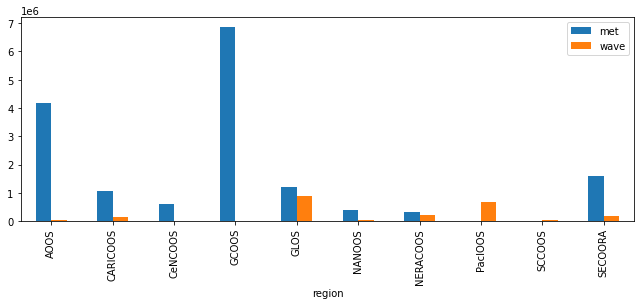

In [4]:
groups = df.groupby("region")

ax = groups.sum().plot(kind="bar", figsize=(11, 3.75))

In [5]:
import pandas as pd


df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
groups = df.groupby(pd.Grouper(key="time (UTC)", freq="M"))

# By month per variable

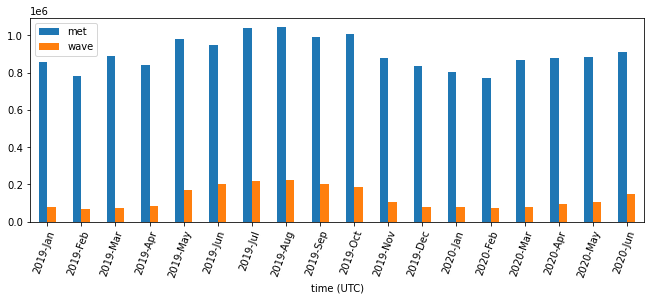

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(11, 3.75))

s = groups.sum()
s.plot(ax=ax, kind="bar")

ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"), rotation=70, rotation_mode="anchor", ha="right"
);

# By month totals

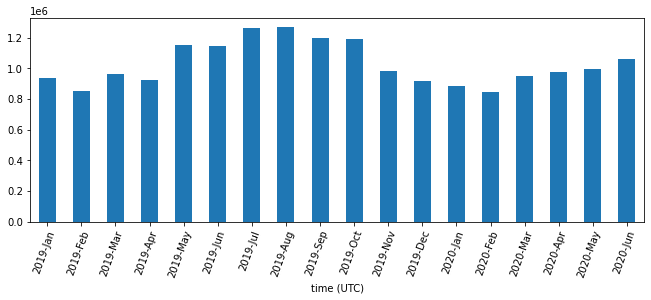

In [7]:
fig, ax = plt.subplots(figsize=(11, 3.75))

s = groups.sum().sum(axis=1)
s.plot(ax=ax, kind="bar")

ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"), rotation=70, rotation_mode="anchor", ha="right"
);

# By location

In [8]:
groups = df.groupby("locationID")
location_sum = groups.sum()

In [9]:
extra_cols = pd.DataFrame(
    {k: buoys.get(k) for k, row in location_sum.iterrows()}
).T
extra_cols = extra_cols[["lat", "lon", "type", "pgm", "name"]]

map_df = pd.concat([location_sum, extra_cols], axis=1)
map_df = map_df.loc[map_df["met"] + map_df["wave"] > 0]

In [10]:
import folium
from folium.plugins import Fullscreen


m = folium.Map()
Fullscreen().add_to(m)


def make_popup(row):
    classes = "table table-striped table-hover table-condensed table-responsive"
    return pd.DataFrame(
        row[["met", "wave", "type", "name", "pgm"]]
    ).to_html(classes=classes)

for k, row in map_df.iterrows():
    if (row["met"] + row["wave"]) > 0:
        if row["met"] == 0:
            color = "red"
        elif row["wave"] == 0:
            color = "orange"
        else:
            color = "green"
        icon = folium.Icon(
            color=color,
        )
        folium.Marker(
            location=[row["lat"], row["lon"]],
            popup=folium.Popup(make_popup(row)),
            icon=icon,
        ).add_to(m)

m